# Detectable Number

## COMPAS
* HP (https://compas.science/)
* GitHub (https://compas.readthedocs.io/en/latest/)
* Patameter List (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification.html)
    * Stellar Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-stellar.html)
    * Binary Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-binary.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import seaborn as sns
from scipy.interpolate import interp1d

import pickle
import bisect
import os
import glob

import h5py as h5
from astropy.table import  unique, vstack, Table, Column, join
import astropy.units as u
from astropy import constants as const
from scipy.stats import norm as NormDist
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

# Chosen cosmology 
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

import sys

##############################
# This path points to the COMPAS functions in your local folder,
# I've redefined most in this notebook anyway, but I was lazy w.r.t the kroupa IMF etc. 
sys.path.insert(0,'/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/')

import FastCosmicIntegration as COMPAS_sfrd
import ClassCOMPAS as COMPAS_class

from importlib import reload  # Python 3.4+
reload(COMPAS_sfrd)

<module 'FastCosmicIntegration' from '/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/FastCosmicIntegration.py'>

## PLOT setttings

In [2]:
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

## Constant Parameters

In [3]:
# physical constants
G = 6.67428e-8 # Gravitational Constant (dyn cm^2 / g^2)
c = 2.99792458e10 # Light Speed (cm/s)

# mass [g]
mp =  1.673e-24 # Proton Mass
me = 9.1093837015e-28 # Electron Mass
 
# solar quantities
sigma = 5.67e-5 #Stefan-Boltzmann Constant (erg/cm^2/K^4/s)
Msun = 1.99e33 # Solar Mass [g]
Lsun = 3.839e33 # Solar Luminosity [erg/s]
Rsun = 6.955e10 # Solar Radius [cm]
Tsun = (Lsun / (4*np.pi*Rsun**2*sigma))**0.25 # Solar Photospheric Temperature [K]
Zsun = 0.014 # Solar Metallicity

# time [s]
hr = 3600.0 # Hour
day = 24.0*hr # Day
yr =  365.25*day # Year
Myr = 1e6*yr # Mega Year
Gyr = 1e9*yr # Giga Year

# distance [cm]
pc = 3.086e18 # Parsec
Mpc = 1e6*pc # Mega Parsec
Gpc = 1e9*pc # Giga Parsec

q = 4.80320425e-10 
r_e = (q**2/(me*c**2))
sigT = (8.*np.pi/3.) * r_e**2

# frequency [Hz]
MHz = 1e6 # Mega Hertz
GHz = 1e9 # Giga Hertz

# radiation [erg/s/cm^2/Hz]
Jy = 1e-23 # Jansky
mJy = 1e-6 * Jy # Milli Jansky
uJy = 1e-9 * Jy # Micro Jansky

## Path Setting & Data Reading

In [4]:
COMPAS_result_dir = '/home/jovyan/COMPAS_02.35.02_N1e7_Fiducial_AllDCO_AIS/'
pathToData = COMPAS_result_dir+'MainRun/COMPAS_Output_wWeights.h5'

# Read data and put in astropy table
File        = h5.File(pathToData ,'r')
SYS_keys  = ['SEED', 'mixture_weight', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Metallicity@ZAMS(1)', 'CE_Event_Counter', 
             'Merger', 'Optimistic_CE', 'Immediate_RLOF>CE']
SYS = Table()
for key in SYS_keys:
    SYS[key] = File['BSE_System_Parameters'][key][()] 
File.close()

with open('./sampling_data/mt_edd100.pkl', 'rb') as file:
    mt_edd100 = pickle.load(file)
    
with open('./sampling_data/ce_edd100.pkl', 'rb') as file:
    ce_edd100 = pickle.load(file)
    
SYS_mt = SYS[np.in1d(SYS['SEED'], mt_edd100['SEED'])]
SYS_ce = SYS[np.in1d(SYS['SEED'], ce_edd100['SEED'])]

mt = join(SYS_mt, mt_edd100, keys='SEED')
ce = join(SYS_ce, ce_edd100, keys='SEED')

mt_mask_Tnan = ~np.isnan(mt['Teff(D)'])
ce_mask_Tnan = ~np.isnan(ce['Teff(D)'])
mt = mt[mt_mask_Tnan]
ce = ce[ce_mask_Tnan]

# COMPAS data
* Compute Star Forming Mass
* Compute Star Formation Rate Density (SFRD)
* Compute Metallicity Distribution
* Compute Formation Rate

In [5]:
def find_star_forming_mass_per_binary_sampling(m1=0.01, m2=0.08, m3=0.5, m4=200.0, a12=0.3, a23=1.3, a34=2.3,
                                               primary_mass_inverse_CDF=None, mass_ratio_inverse_CDF=None, SAMPLES=20000000, 
                                               binaryFraction = 0.7, Mlower = 10.* u.Msun, Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun):
    """
        Calculate the star forming mass evolved for each binary in the file.
        This function does this by sampling from the IMF and mass ratio distributions

        Args:
            mi                       --> [float]    masses at which to transition the slope of the IMF (ignored if primary_mass_inverse_CDF is not None)
            aij                      --> [float]    slope of the IMF between mi and mj (ignored if primary_mass_inverse_CDF is not None)
            primary_mass_inverse_CDF --> [function] a function that computes the inverse CDF functoin for the primary mass distribution
                                                    this defaults to the Kroupa IMF (which can be varied using mi, aij)
            mass_ratio_inverse_CDF   --> [function] a function that computes the inverse CDF function for the mass ratio distribution
                                                    this defaults to assuming a uniform mass ratio on [0, 1]
            SAMPLES                  --> [int]      number of samples to draw when creating a mock universe
            binaryFraction           --> [int]      Asusmed binary fraction, default = 0.7
            Mlower                   --> [int]      Minimum primary mass sampled by COMPAS default = 10 
            Mupper                   --> [int]      Maximum primary mass sampled by COMPAS default = 150
            m2_min                   --> [int]       Minimum secondary mass sampled by COMPAS default = 0.1
    """
    # if primary mass inverse CDF is None, assume the Kroupa IMF
    if primary_mass_inverse_CDF is None:
        primary_mass_inverse_CDF = lambda U: COMPAS_class.inverse_CDF_IMF(U, m1=m1, m2=m2, m3=m3, m4=m4, a12=a12, a23=a23, a34=a34)

    # if mass ratio inverse CDF function is None, assume uniform
    if mass_ratio_inverse_CDF is None:
        mass_ratio_inverse_CDF = lambda q: q

    # randomly sample a large number of masses from IMF, mass ratios from supplied function, binary for boolean
    primary_mass = primary_mass_inverse_CDF(np.random.rand(SAMPLES)) * u.Msun
    mass_ratio = mass_ratio_inverse_CDF(np.random.rand(SAMPLES))
    binary = np.random.rand(SAMPLES)

    # only fbin fraction of stars have a secondary (in a binary)
    binary_mask = binary < binaryFraction

    # assign each a random secondary mass, default 0 because single stars have m2=0 (surprisingly :P)
    secondary_mass = np.zeros(SAMPLES) * u.Msun
    secondary_mass[binary_mask] = primary_mass[binary_mask] * mass_ratio[binary_mask]

    # find the total mass of the whole population
    total_mass = np.sum(primary_mass) + np.sum(secondary_mass)

    # apply the COMPAS cuts on primary and secondary mass
    primary_mask = np.logical_and(primary_mass >= Mlower, primary_mass <= Mupper)
    secondary_mask = secondary_mass > m2_min
    full_mask = np.logical_and(primary_mask, secondary_mask)

    # find the total mass with COMPAS cuts
    total_mass_COMPAS = np.sum(primary_mass[full_mask]) + np.sum(secondary_mass[full_mask])

    # use the totals to find the ratio and return the average mass as well
    f_mass_sampled = total_mass_COMPAS / total_mass
    average_mass_COMPAS = total_mass_COMPAS / len(primary_mass[full_mask])

    # find the average star forming mass evolved per binary in the Universe
    mass_evolved_per_binary = average_mass_COMPAS / f_mass_sampled
    
    return mass_evolved_per_binary

In [6]:
def find_sfr(redshifts, a = 0.01, b =2.77, c = 2.90, d = 4.70):
    """
        Calculate the star forming mass per unit volume per year following
        Neijssel+19 Eq. 6, using functional form of Madau & Dickinson 2014

        Args:
            redshifts --> [list of floats] List of redshifts at which to evaluate the sfr

        Returns:
            sfr       --> [list of floats] Star forming mass per unit volume per year for each redshift
    """
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value

In [7]:
def find_metallicity_distribution(redshifts = 0,  min_logZ_COMPAS = np.log(0.0001), max_logZ_COMPAS = np.log(0.03),
                                  # mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0,
                                  mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):

    #     redshifts, np.log(0.0001),# np.log(0.03),
    #                                   mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0,
    #                                   min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):
    # mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,

    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    =  0.035    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.25     --> [float]           redshift scaling/evolution of the location
        sigma_0 = 0.39     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.00     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = 0.00     --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> [float]          Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """ 
    ##################################
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts) 
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma) 
    mu_metallicities = np.log(mean_metallicities/2. * 1./(np.exp(0.5*sigma**2) * PHI )  ) 

    ##################################
    # create a range of metallicities (thex-values, or random variables)
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)


    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, p_draw_metallicity

In [8]:
def find_formation_rates(n_binaries, redshifts, n_formed, dPdlogZ, metallicities, p_draw_metallicity,
                         COMPAS_metallicites, COMPAS_weights=None):
    """
        Find both the formation and merger rates for each binary at each redshift

        Args:
            n_binaries          --> [int]            Number of DCO binaries in the arrays
            redshifts           --> [list of floats] Redshifts at which to evaluate the rates
            n_formed            --> [float]          Binary formation rate (number of binaries formed per year per cubic Gpc) represented by each simulated COMPAS binary
            dPdlogZ             --> [2D float array] Probability of getting a particular logZ at a certain redshift
            metallicities       --> [list of floats] Metallicities at which dPdlogZ is evaluated; if this is None, assume that metallicity weighting is 1 (corresponds to all SFR happening at one fixed metallicity)
            p_draw_metallicity  --> [float]          Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
            COMPAS_metallicites --> [list of floats] Metallicity of each binary in COMPAS data
            COMPAS_weights      --> [list of floats] Adaptive sampling weights for each binary in COMPAS data (defaults to all 1s for unweighted samples)

        Returns:
            formation_rate      --> [2D float array] Formation rate for each binary at each redshift
    """
    # check if weights were provided, if not use uniform weights
    if COMPAS_weights is None:
        COMPAS_weights = np.ones(n_binaries)

    # initialise rates to zero
    n_redshifts = len(redshifts)
    formation_rate = np.zeros(shape=(n_binaries, n_redshifts))

    # go through each binary in the COMPAS data
    for i in range(n_binaries):
        # if metallicities array is None, assume all SFR happened at one fixed metallicity
        if metallicities is None :
            formation_rate[i, :] = n_formed * COMPAS_weights[i]
        # calculate formation rate (see Neijssel+19 Section 4) - note this uses dPdlogZ for *closest* metallicity
        else:
            formation_rate[i, :] = n_formed * dPdlogZ[:, np.digitize(COMPAS_metallicites[i], metallicities)] / p_draw_metallicity * COMPAS_weights[i]

    return formation_rate

In [9]:
n_systems = len(SYS['SEED'])
M1_min    = np.min(SYS['Mass@ZAMS(1)'][()]) #minimum ZAMS mass simulated

mass_evolved_per_binary = find_star_forming_mass_per_binary_sampling(binaryFraction = 0.7, Mlower = M1_min* u.Msun, 
                                                                     Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun)
Average_SF_mass_needed = (mass_evolved_per_binary * n_systems)

redshifts = np.linspace(0,1,100)
H0_burns = 73.2 * u.km / u.s / u.Mpc # the Hubble constant derived from Burns et al. (2018)
cosmo_burns = FlatLambdaCDM(H0=H0_burns, Om0=0.3)
d_L = cosmo_burns.luminosity_distance(redshifts)

sfr = find_sfr(redshifts)
dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(redshifts)

### Formation Rate

Check the parameter range

In [10]:
mt_mdot_min = mt['Eddington'].min()
mt_mdot_max = mt['Eddington'].max()
ce_mdot_min = ce['Eddington'].min()
ce_mdot_max = ce['Eddington'].max()

mt_t_min = mt['Timescale'].min()
mt_t_max = mt['Timescale'].max()
ce_t_min = ce['Timescale'].min()
ce_t_max = ce['Timescale'].max()

print(f'MT Mdot Min: {mt_mdot_min:.2E}')
print(f'MT Mdot Max: {mt_mdot_max:.2E}')
print(f'CE Mdot Min: {ce_mdot_min:.2E}')
print(f'CE Mdot Max: {ce_mdot_max:.2E}')

print(f'MT t Min: {mt_t_min:.2E}')
print(f'MT t Max: {mt_t_max:.2E}')
print(f'CE t Min: {ce_t_min:.2E}')
print(f'CE t Max: {ce_t_max:.2E}')

MT Mdot Min: 1.00E+02
MT Mdot Max: 1.31E+08
CE Mdot Min: 1.00E+02
CE Mdot Max: 4.92E+08
MT t Min: 1.00E-06
MT t Max: 6.24E-01
CE t Min: 3.67E-07
CE t Max: 3.17E+00


In [11]:
mdot_bin = np.logspace(np.log10(1e2), np.log10(ce_mdot_max), 21)
t_bin = np.logspace(np.log10(ce_t_min), np.log10(ce_t_max), 19)

mdot_center = np.sqrt(mdot_bin[:-1] * mdot_bin[1:])
t_center = np.sqrt(t_bin[:-1] * t_bin[1:])

In [12]:
def formation_rate_z(redshifts=redshifts, sfr=sfr, Average_SF_mass_needed=Average_SF_mass_needed, 
                     dPdlogZ=dPdlogZ, metallicities=metallicities, p_draw_metallicity=p_draw_metallicity,
                     mt=mt, ce=ce, mdot_bin=mdot_bin, t_bin=t_bin, mdot_center=mdot_center, t_center=t_center):
    """
    Compute formation rate as a function of redshift z
    
    Args:
        redshifts               --> [list of floats] List of redshifts at which to evaluate the sfr
        sfr                     --> [list of floats] Star forming mass per unit volume per year for each redshift
        Average_SF_mass_needed  --> [Astropy Table]  Star forming pass for a COMPAS simulation

        dPdlogZ                 --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities           --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity      --> [float]          Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
        
        mt                      --> [Astropy Table]  astropy table of RLOF systems
        ce                      --> [Astropy Table]  astropy table of CE systems
        
        mdot_bin                --> [list of floats] binning range for Mdot
        t_bin                   --> [list of floats] binning range for t_active
        mdot_center             --> [list of floats] center values of Mdot bins
        t_center                --> [list of floats] center values of t_active bins
        
    Returns:
        rate_table              --> [Astropy Table]  astropy table including 'Mdot', 't_active', 'rate'
    """
    
    n_mt = len(mt['SEED'])
    n_ce = len(ce['SEED'])
    n_formed = sfr / Average_SF_mass_needed.value

    mt_formation_rate = find_formation_rates(n_mt, redshifts, n_formed, dPdlogZ, metallicities, p_draw_metallicity,
                                         mt['Metallicity@ZAMS(1)'], mt['mixture_weight'])
    ce_formation_rate = find_formation_rates(n_ce, redshifts, n_formed, dPdlogZ, metallicities, p_draw_metallicity,
                                         ce['Metallicity@ZAMS(1)'], ce['mixture_weight'])
    
    hist_3d = np.zeros((len(mdot_center), len(t_center), len(redshifts)))
    for i in range(len(redshifts)):
        mt_rate = mt_formation_rate[:, i]
        ce_rate = ce_formation_rate[:, i]
    
        hist_mt, _, _  = np.histogram2d(mt['Eddington'], mt['Timescale'], 
                                        bins=(mdot_bin, t_bin), weights=mt_rate)
        hist_ce, _, _  = np.histogram2d(ce['Eddington'], ce['Timescale'], 
                                        bins=(mdot_bin, t_bin), weights=ce_rate)
        hist = hist_mt + hist_ce
        hist_3d[:, :, i] = hist
        
    Mdot_list = []
    tacc_list = []
    rate_list = []
    # Populate the results array with (mdot_center, t_center, all z values) tuples
    for i, mdot_val in enumerate(mdot_center):
        for j, t_val in enumerate(t_center):
            z_val = hist_3d[i, j, :]
            Mdot_list.append(mdot_val)
            tacc_list.append(t_val*1e6)
            rate_list.append(z_val)

    rate_table = Table()
    rate_table['Mdot'] = Mdot_list
    rate_table['t_active'] = tacc_list
    rate_table['rate']= rate_list
    
    return rate_table

In [13]:
rate_table = formation_rate_z()

# Light Curve Data

## Constant parameters

In [14]:
# parameter range (check the consistency with Hypernebula.py)
t = 0.1*(1.0+10**np.linspace(-2,7.5,1200)) #yr
nu = 1e9 * 10**np.linspace(-3.0,3.2,120) #Hz

# Central frequency of survey
nu_vlass = 3*GHz
nu_lotss = 140*MHz
nu_vlite = 350*MHz
nu_vast = 880*MHz
nu_thunderkat = 1.28*GHz
nu_dsa = 1*GHz

# Limiting sensitivity
fnu_vlass = 700*uJy
fnu_lotss = 95*uJy
fnu_vlite = 7000*uJy
fnu_vast = 240*uJy
fnu_thunderkat = 100*uJy
fnu_dsa = 10*uJy

# Sky coverage
cov_vlass = 34000/41252
cov_lotss = 40000/41252
cov_vlite = 40000/41252
cov_vast = 10000/41252
cov_thunderkat = 40000/41252
cov_dsa = 30000/41252

In [15]:
def tabobj_to_array(table_object):
    """
    smoothing function
    Args:
        table_object --> [list of objects] list of objects in Astropy Table
        
    Returns:
        result_array --> [list of floats]  float list
    """     
    
    # リスト内の配列を1次元に展開します
    flattened_data = [element for sublist in table_object for element in sublist]

    # 1次元配列に変換します
    result_array = np.array(flattened_data)
    
    return result_array

In [16]:
def smooth(y, box_pts=20):
    """
    smoothing function
    Args:
        y        --> [list of floats]  list of values to be smoothed
        box_pts  --> [int]             box size of smoothing
        
    Returns:
        y_smooth --> [list of floats]  smoothed values
    """ 
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [17]:
def nuLnu (data, nu_survey, time):
    """
    calculate nuLnu
    Args:
        data           --> [dict]            output of Hypernebula.py
        nu_survey      --> [int]             central frequency of the survey
        time           --> [list of floats]  time adjusting the light curve duration
        
    Returns:
        smoothed_nuLnu --> [list of floats]  smoothed light curve
    """ 
    
    #initialization
    nuLnu = []
    for i in range(len(time)):
        
        # interpolation
        Lnu_interp = interp1d(nu, data['Lnu_syn'][i], kind='linear', fill_value="extrapolate")
        Lnu_GHz = Lnu_interp(nu_survey)
        nuLnu.append(Lnu_GHz * nu_survey)

    return nuLnu

In [18]:
def read_lc (dir_path):
    """
    Read the output files by Hypernebula.py
    Args:
        dir_path --> [char]          path to the output directly of Hypernebula.py
        
    Returns:
        lc_table --> [Astropy Table] Astropy table including 'Mdot', 't_active', and 'nuLnu' for each surveys
    """ 
    
    # make the file name list
    pkl_files = glob.glob(os.path.join(dir_path, '*.pkl'))    
    
    # initialization
    Mdot = []
    t_active = []
    v_w = []
    v_j = []
    epsilon_e = []
    sigma = []
    eta = []
    
    lc_vlass = []
    lc_lotss = []
    lc_vlite = []
    lc_vast = []
    lc_thunderkat = []
    lc_dsa = []

    for file_path in pkl_files:
        with open(file_path, 'rb') as file:
            try:
                loaddata = pickle.load(file)
                
                Mdot.append(loaddata['params']['Mdot_w'])
                t_active.append(loaddata['params']['t_active'])
                v_w.append(loaddata['params']['v_w'])
                v_j.append(loaddata['params']['v_j'])
                epsilon_e.append(loaddata['params']['epsilon_e'])
                sigma.append(loaddata['params']['sigma'])
                eta.append(loaddata['params']['eta'])
                
                time = t[t <= 100*loaddata['params']['t_active']]
                lc_vlass.append(nuLnu(loaddata, nu_vlass, time))
                lc_lotss.append(nuLnu(loaddata, nu_lotss, time))
                lc_vlite.append(nuLnu(loaddata, nu_vlite, time))
                lc_vast.append(nuLnu(loaddata, nu_vast, time))
                lc_thunderkat.append(nuLnu(loaddata, nu_thunderkat, time))
                lc_dsa.append(nuLnu(loaddata, nu_dsa, time))
                    
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                
    data_dicts = [{'Mdot': param1, 't_active': param2, 'v_w': param3, 'v_j': param4, 
                   'epsilon_e': param5, 'sigma':param6, 'eta': param7,
                   'vlass': lc1, 'lotss': lc2, 'vlite': lc3, 'vast': lc4, 'thunderkat': lc5, 'dsa': lc6} 
                  for param1, param2, param3, param4, param5, param6, param7, lc1, lc2, lc3, lc4, lc5, lc6 in 
                  zip(Mdot, t_active, v_w, v_j, epsilon_e, sigma, eta, 
                      lc_vlass, lc_lotss, lc_vlite, lc_vast, lc_thunderkat, lc_dsa)]
    
    data = pd.DataFrame(data_dicts) #.sort_values(by=['Mdot', 't_active']).reset_index(drop=True)
    lc_table = Table.from_pandas(data)
    
    return lc_table

In [19]:
dir_path = '../code/Hypernebula-grid/models_003_01_01_01_01/'
lc_table = read_lc(dir_path)

## Compute Detectable Number
The number of detectable super-Eddington binaries ($N_{\mathrm{det}}$) is determined by the convolution of the hypernebula rate, the source luminosity ($(L_{\nu}$), and the limiting sensitivity of telescopes ($F_{\nu, \mathrm{lim}}$). We can calculate the detectable horizon ($D_{\mathrm{lim}}$) according to:
$$
    D_{\mathrm{lim}} (L_{\nu}(t), F_{\nu, \mathrm{lim}}) = \left( \frac{L_{\nu}(t)}{4\pi F_{\nu, \mathrm{lim}}} \right)^{1/2}.
$$
The detectable number at a distance of $D \leq D_{\mathrm{lim}, \max}$ is determined as follows:
$$
    \mathcal{N}_{\mathrm{det}}(D) = \int_{0}^{\Delta t} \int_{0}^{D \leq D_{\mathrm{lim}, \max}} \frac{4}{3}\pi r^3 \mathcal{R} dr dt,
$$
where $\Delta t$ is the time duration with the source flux beyond the limiting sensitivity, which is characterized by the accretion timescale $(t_{\mathrm{acc}})$ and the Eddington ratio.

In [20]:
def calculate_dt(fnu, time, fnu_lim):
    """
    Compute the time duration above the limiting sensitivity
    
    Args:
        fnu           --> [list of floats]   light curve of radio flux [erg/s/cm^2/Hz]
        time          --> [list of floats]   time of the light curve [s]
        fnu_lim       --> [float]            limiting sensitivity [erg/s/cm^2/Hz]
        
    Returns:
        max_duration  --> [float]            time duration above the limiting sensitivity [s]
    """ 
    
    # initialization
    max_duration = 0
    current_duration = 0
    
    # compute the maximum duration above the limiting sensitivity
    for i in range(len(fnu) - 1):
        if fnu[i] > fnu_lim: #above the sentisitivy
            current_duration += time[i+1] - time[i]
        else:
            if current_duration > max_duration: # check whether the duration is maximun or not
                max_duration = current_duration
            current_duration = 0

    # check whether dt of the final step is the maximum or not
    if current_duration > max_duration:
        max_duration = current_duration
        
    return max_duration

In [21]:
def find_nearest_index(mdot, tacc, rate_table):
    """
    Find the index of the element in rate_table that is closest to the given mdot and tacc values.
    
    Args:
        mdot        --> [float]          accretion rate
        tacc        --> [float]          accreting timescale
        rate_table  --> [Astropy Table]  astropy table including the columns of 'Mdot', 't_active', 'rate'
        
    Returns:
        min_index   --> [int]            the index of the rate_table, corresponding to the closest values to the given parameters
    """
    
    # Calculate the Euclidean distance between each (mdot, tacc) pair in rate_table and the given (mdot, tacc) values
    distances = np.sqrt((rate_table['Mdot'] - mdot)**2 + (rate_table['t_active'] - tacc)**2)
    
    # Find the index of the minimum distance
    min_index = np.argmin(distances)
    
    return min_index

In [22]:
def compute_detectable_number(rate, lc, survey, nu_survey, fnu_survey):
    """
    Compute the detectable number and detectable horizaon as a function of distance
    
    Args:
        rate         --> [Astropy Table]  astropy table including the columns of 'Mdot', 't_active', 'rate'
        lc           --> [Astropy Table]  astropy table including the columns of 'Mdot', 't_active', 'lc'
        survey       --> [char]           survey name 
        nu_survey    --> [float]          central frequency of the survey [Hz]
        fnu_survey   --> [float]          limiting sensitivity of the survey [erg/s/cm^2/Hz] (NOT Jy)
        
    Returns:
        Ndet         --> [list of floats] cumulative of the detectable number of hypernebulae as a function of distance
        Dlim         --> [float]          the maximum detectable horizon at the luminosity [cm]
    """

    # calculate the central rate at the bins
    rate_center = (rate[:-1] + rate[1:])/2 /Gpc**3/yr #/cm^3/s
    
    # read luminosity distance & caluculate the central distance et the bins
    r = d_L.value * Mpc #cm
    r_center = (r[:-1] + r[1:])/2 #cm
    
    # read time ajdusting to the range of the light curves
    time = t[t <= 100*lc['t_active']]*yr #s
    
    # convert the nuLnu to Lnu
    Lnu = smooth(lc[survey]) / nu_survey # erg/s/Hz
    # Lnu = smooth(lc[survey]) / nu_survey
    
    # compute fnu(r) & dt
    dt = np.zeros(len(r_center))
    for i, dist in enumerate(r_center):
        fnu_r = Lnu / (4 * np.pi * dist**2)  # erg/s/cm^2/Hz
        dt[i] = calculate_dt(fnu_r, time, fnu_survey)  # s

    # compute the shell volume
    V_shell = (4 / 3) * np.pi * ((r[1:]**3 - r[:-1]**3))  # cm^3

    # detectable number including each shell
    dNdet = rate_center * V_shell * dt

    # cumulative of detectable number
    Ndet = np.cumsum(dNdet)

    # add 0 into the head
    Ndet = np.insert(Ndet, 0, 0)
    
    return Ndet, Lnu, dt

In [23]:
def compute_cumulative_detectable_number (rate_talbe, lc_table):
    """
    Compute the cumulative of detectable numbers of each surveys
    
    Args:
        rate_table  --> [Astropy Table]  astropy table including the columns of 'Mdot', 't_active', 'rate'
        lc_table    --> [Astropy Table]  astropy table including the columns of 'Mdot', 't_active', 'lc'
        
    Returns:
        Ndet        --> [Astropy Table]  cumulative of the detectable number of hypernebulae 
                                         as a function of distance for each surveys
    """
    
    # initialize the list
    Ndet_vlass = []
    Ndet_lotss = []
    Ndet_vlite = []
    Ndet_vast = []
    Ndet_thunderkat = []
    Ndet_dsa = []
    
    Lnu_vlass = []
    Lnu_lotss = []
    Lnu_vlite = []
    Lnu_vast = []
    Lnu_thunderkat = []
    Lnu_dsa = []
    
    dt_vlass = []
    dt_lotss = []
    dt_vlite = []
    dt_vast = []
    dt_thunderkat = []
    dt_dsa = []

    for i in range(len(lc_table)):
        
        # read the light curve table at the index of i
        lc = lc_table[i]
        mdot = lc['Mdot']
        tacc = lc['t_active']
        
        # find the index in the rate table with the closest values to (mdot, tacc)
        closest_index = find_nearest_index(mdot, tacc, rate_table)
        rate = rate_table['rate'][closest_index]
        
        # compute the detectable number using 'compute_detectable_number' function
        ###
        N, Lnu, dt = compute_detectable_number(rate, lc, 'vlass', nu_vlass, fnu_vlass)
        Ndet_vlass.append(N)
        Lnu_vlass.append(Lnu)
        dt_vlass.append(dt)
        
        N, Lnu, dt = compute_detectable_number(rate, lc, 'lotss', nu_lotss, fnu_lotss)
        Ndet_lotss.append(N)
        Lnu_lotss.append(Lnu)
        dt_lotss.append(dt)
        
        N, Lnu, dt = compute_detectable_number(rate, lc, 'vlite', nu_vlite, fnu_vlite)
        Ndet_vlite.append(N)
        Lnu_vlite.append(Lnu)
        dt_vlite.append(dt)
        
        N, Lnu, dt = compute_detectable_number(rate, lc, 'vast', nu_vast, fnu_vast)
        Ndet_vast.append(N)
        Lnu_vast.append(Lnu)
        dt_vast.append(dt)
        
        N, Lnu, dt = compute_detectable_number(rate, lc, 'thunderkat', nu_thunderkat, fnu_thunderkat)
        Ndet_thunderkat.append(N)
        Lnu_thunderkat.append(Lnu)
        dt_thunderkat.append(dt)
        
        N, Lnu, dt = compute_detectable_number(rate, lc, 'dsa', nu_dsa, fnu_dsa)
        Ndet_dsa.append(N)
        Lnu_dsa.append(Lnu)
        dt_dsa.append(dt)
        ###
        
    # save the values
    Ndet = Table()
    Ndet['Mdot'] = lc_table['Mdot']
    Ndet['t_active'] = lc_table['t_active']
    Ndet['N_vlass'] = Ndet_vlass
    Ndet['N_lotss'] = Ndet_lotss
    Ndet['N_vlite'] = Ndet_vlite
    Ndet['N_vast'] = Ndet_vast
    Ndet['N_thunderkat'] = Ndet_thunderkat
    Ndet['N_dsa'] = Ndet_dsa
    
    Ndet['Lnu_vlass'] = Lnu_vlass
    Ndet['Lnu_lotss'] = Lnu_lotss
    Ndet['Lnu_vlite'] = Lnu_vlite
    Ndet['Lnu_vast'] = Lnu_vast
    Ndet['Lnu_thunderkat'] = Lnu_thunderkat
    Ndet['Lnu_dsa'] = Lnu_dsa
    
    Ndet['dt_vlass'] = dt_vlass
    Ndet['dt_lotss'] = dt_lotss
    Ndet['dt_vlite'] = dt_vlite
    Ndet['dt_vast'] = dt_vast
    Ndet['dt_thunderkat'] = dt_thunderkat
    Ndet['dt_dsa'] = dt_dsa
    
    return Ndet

In [24]:
Ndet = compute_cumulative_detectable_number (rate_table, lc_table)

In [25]:
sum_vlass = np.sum(Ndet['N_vlass'], axis=0)
sum_lotss = np.sum(Ndet['N_lotss'], axis=0)
sum_vlite = np.sum(Ndet['N_vlite'], axis=0)
sum_vast = np.sum(Ndet['N_vast'], axis=0)
sum_thunderkat = np.sum(Ndet['N_thunderkat'], axis=0)
sum_dsa = np.sum(Ndet['N_dsa'], axis=0)

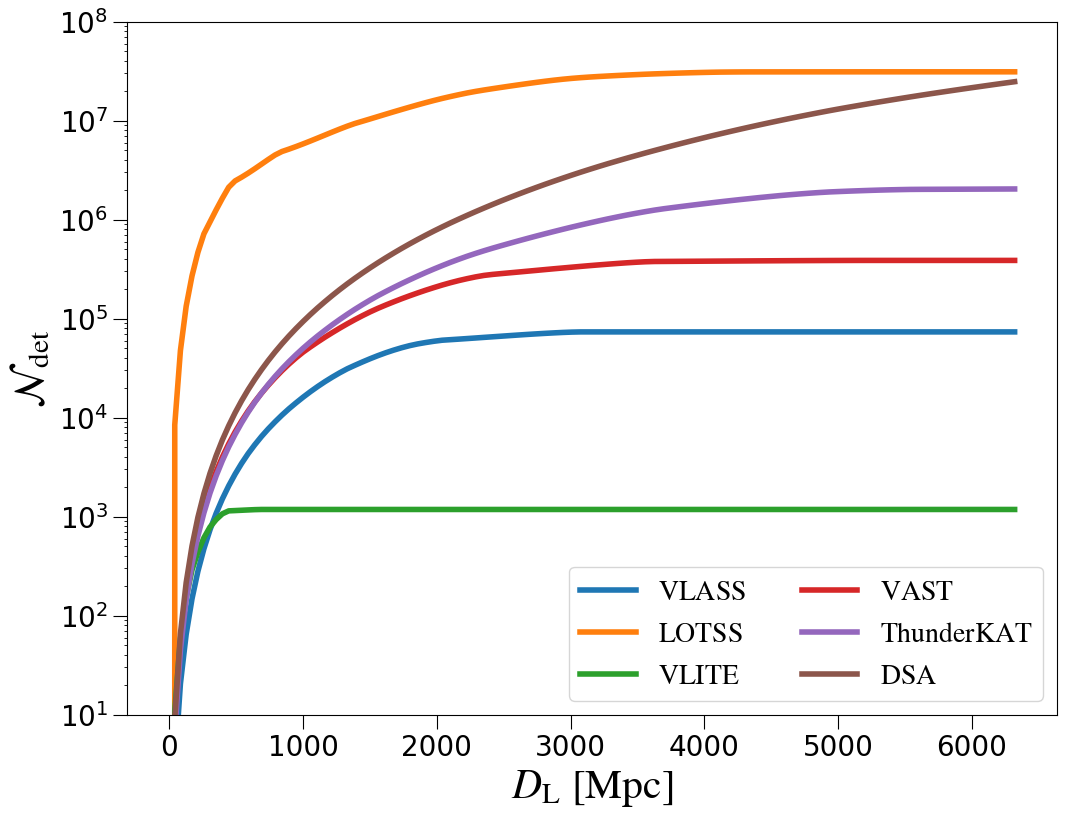

In [26]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.plot(d_L.value, sum_vlass, label=r'$\mathrm{VLASS}$', lw=4)
ax.plot(d_L.value, sum_lotss, label=r'$\mathrm{LOTSS}$', lw=4)
ax.plot(d_L.value, sum_vlite, label=r'$\mathrm{VLITE}$', lw=4)
ax.plot(d_L.value, sum_vast, label=r'$\mathrm{VAST}$', lw=4)
ax.plot(d_L.value, sum_thunderkat, label=r'$\mathrm{ThunderKAT}$', lw=4)
ax.plot(d_L.value, sum_dsa, label=r'$\mathrm{DSA}$', lw=4)

########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

# ax.set_xlim([0.0, 50])
ax.set_ylim([1e1, 1e8])

plt.xlabel(r'$D_{\mathrm{L}} \ {\mathrm{[Mpc]}}$', fontsize = 30)
plt.ylabel(r'$\mathcal{N}_{\mathrm{det}}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 20, ncol=2)
plt.savefig('./figures/cumulative_N_01_01.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()